# Idee
--controllare la qualità delle bottiglie provenienti dal singolo produttore? 
modello per indovinare la regione dalle descrizioni? difficile? 

-- in base agli aggettivi della descrizione e alla regione prevedere il vino? o solo la tipologia? il prezzo? boh

-- classificare i vini in base alle descrizioni in cluster? a cosa può servire?

-- quanto DOVREBBE costare una bottiglia rispetto alle recensioni ricevute?  "percieved value"

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
data = pd.read_csv("winemag-data-130k-v2.csv")
data.drop(columns=["Unnamed: 0"],inplace=True)
len(data)

129971

In [2]:
data

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,NaN,Michael Schachner,@wineschach,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem
6,Italy,"Here's a bright, informal red that opens with ...",Belsito,87,16.0,Sicily & Sardinia,Vittoria,NaN,Kerin O’Keefe,@kerinokeefe,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,Terre di Giurfo
7,France,This dry and restrained wine offers spice in p...,NaN,87,24.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Trimbach 2012 Gewurztraminer (Alsace),Gewürztraminer,Trimbach
8,Germany,Savory dried thyme notes accent sunnier flavor...,Shine,87,12.0,Rheinhessen,NaN,NaN,Anna Lee C. Iijima,NaN,Heinz Eifel 2013 Shine Gewürztraminer (Rheinhe...,Gewürztraminer,Heinz Eifel
9,France,This has great depth of flavor with its fresh ...,Les Natures,87,27.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Jean-Baptiste Adam 2012 Les Natures Pinot Gris...,Pinot Gris,Jean-Baptiste Adam


In [3]:
len(data[data.duplicated('description',keep=False)].sort_values('description'))

20026

In [4]:
data = data.drop_duplicates("description")
len(data)
#removes 

119955

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119955 entries, 0 to 129970
Data columns (total 13 columns):
country                  119896 non-null object
description              119955 non-null object
designation              85423 non-null object
points                   119955 non-null int64
price                    111567 non-null float64
province                 119896 non-null object
region_1                 100397 non-null object
region_2                 46760 non-null object
taster_name              95043 non-null object
taster_twitter_handle    90514 non-null object
title                    119955 non-null object
variety                  119954 non-null object
winery                   119955 non-null object
dtypes: float64(1), int64(1), object(11)
memory usage: 12.8+ MB


.. tanti null sulla parte della designation, sulel due regioni e sui nomi dei reviewers

In [6]:
len(data["title"].unique())

118807

In [7]:
data["title"].unique()

array(['Nicosia 2013 Vulkà Bianco  (Etna)',
       'Quinta dos Avidagos 2011 Avidagos Red (Douro)',
       'Rainstorm 2013 Pinot Gris (Willamette Valley)', ...,
       'Domaine Gresser 2013 Kritt Gewurztraminer (Alsace)',
       'Domaine Marcel Deiss 2012 Pinot Gris (Alsace)',
       'Domaine Schoffit 2012 Lieu-dit Harth Cuvée Caroline Gewurztraminer (Alsace)'],
      dtype=object)

In [8]:
avgPriceWinery = data.groupby("winery")#.price.mean()
#avgPriceWinery.get_group("1+1=3").price.mean()

sarebbe meglio riempire i nan del prezzo basandosi sulla media dei vini venduti dalla stessa cantina?

In [9]:
d = data.loc[pd.isnull(data["price"])]
wineries = d["winery"].unique().tolist()
data["price"].fillna(data["price"].mean(),inplace=True)
#data["price"] = (lambda x: avgPriceWinery.get_group(data[x["winery"]]).price.mean())
data.head()
#for i in range(0, len(data)):
#    if (pd.isnull(data.loc[i, 'price'])):
#        m = avgPriceWinery.get_group(data.loc[i,"winery"]).price.mean()
 #       data.loc[i, 'price'] = m

#for idx,row in data.iterrows():
 #   if(pd.isnull(row["price"])):
  #      m = avgPriceWinery.get_group(row["winery"]).price.mean()
   #     row.fillna(m,inplace=True)
        #row.loc["price"] = 10
#data["price"].fillna(,inplace=True)
data.fillna("unknown",inplace=True)
#data.head()

E:\Anaconda\lib\site-packages\pandas\core\generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
E:\Anaconda\lib\site-packages\pandas\core\frame.py:3790: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [10]:
from sklearn.preprocessing import LabelEncoder

# encode labels with value between 0 and n_classes-1.
desig_encoder = LabelEncoder()
taster_encoder = LabelEncoder()
variety_encoder = LabelEncoder()
winery_encoder = LabelEncoder()
country_encoder = LabelEncoder()
province_encoder = LabelEncoder()

data['Desig_Code'] = desig_encoder.fit_transform(data['designation'])
data['Taster_Code'] = taster_encoder.fit_transform(data['taster_name'])
data['Variety_Code'] = variety_encoder.fit_transform(data['variety'])
data['Winery_Code'] = winery_encoder.fit_transform(data['winery'])
data['Country_Code'] = winery_encoder.fit_transform(data['country'])
data['Province_Code'] = winery_encoder.fit_transform(data['province'])

data.head()

E:\Anaconda\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
E:\Anaconda\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
E:\Anaconda\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,Desig_Code,Taster_Code,Variety_Code,Winery_Code,Country_Code,Province_Code
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,35.620542,Sicily & Sardinia,Etna,unknown,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia,36801,9,690,11608,22,331
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.000000,Douro,unknown,unknown,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,2324,15,450,12955,31,108
2,US,"Tart and snappy, the flavors of lime flesh and...",unknown,87,14.000000,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,37909,14,436,13017,40,268
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.000000,Michigan,Lake Michigan Shore,unknown,Alexander Peartree,unknown,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,27970,0,479,14389,40,218
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.000000,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,36461,14,440,14620,40,268


In [11]:
#data[data["winery"] == "Aldegheri"]

Probabilmente per le correlation devi trasformare gli attributi da label stringhe a categorico ecc ecc

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]),
 <a list of 8 Text yticklabel objects>)

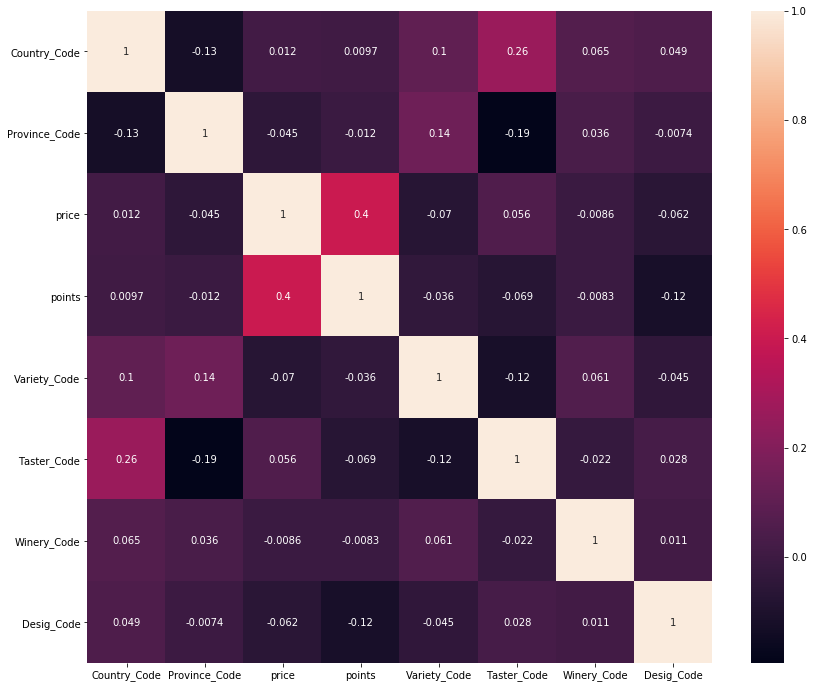

In [12]:
# calculate the correlation matrix
data1 = data[["Country_Code","Province_Code","price","points","Variety_Code","Taster_Code","Winery_Code","Desig_Code"]]
corr = data1.corr()
plt.subplots(figsize =(14, 12))

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,annot=True)
plt.xticks(rotation = 0)
plt.yticks(rotation = 0)

Price e points sono loosely correlated, perchè la correlation fra country e province è così bassa? forse perchè ci sono tanti valori null? 

# DISTRIBUTIONS

E:\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


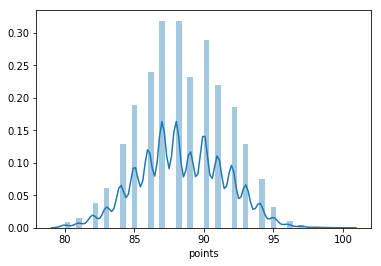

In [13]:
sns.distplot(data["points"])

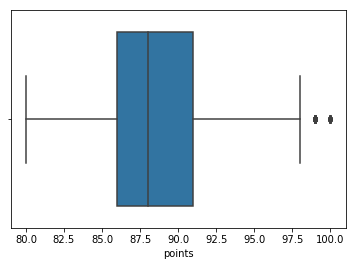

In [14]:
sns.boxplot(data["points"])

E:\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


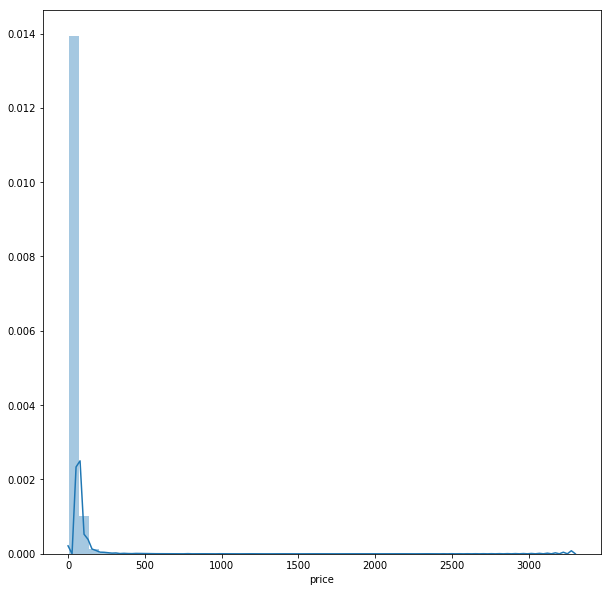

In [15]:
x = data.dropna(subset=["price"])
fig, ax = plt.subplots(figsize = (10, 10))
ax = sns.distplot(x["price"])

La grandissima maggioranza dei vini costa meno di 100 dollari

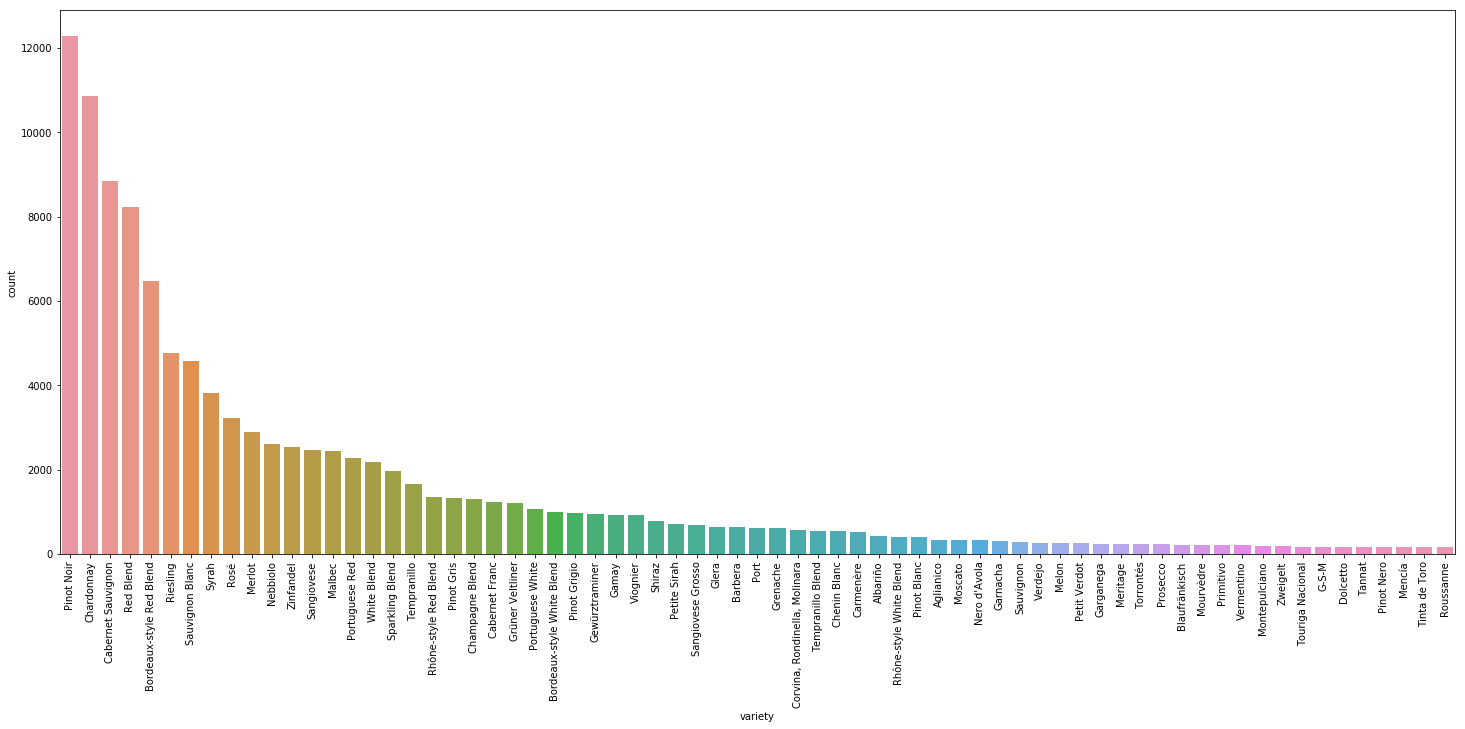

In [16]:
variety_df = data.groupby('variety').filter(lambda x: len(x) > 150)
varieties = variety_df['variety'].value_counts().index.tolist()
fig, ax = plt.subplots(figsize = (25, 10))
sns.countplot(x = variety_df['variety'], order = varieties, ax = ax)
plt.xticks(rotation = 90)
plt.show()

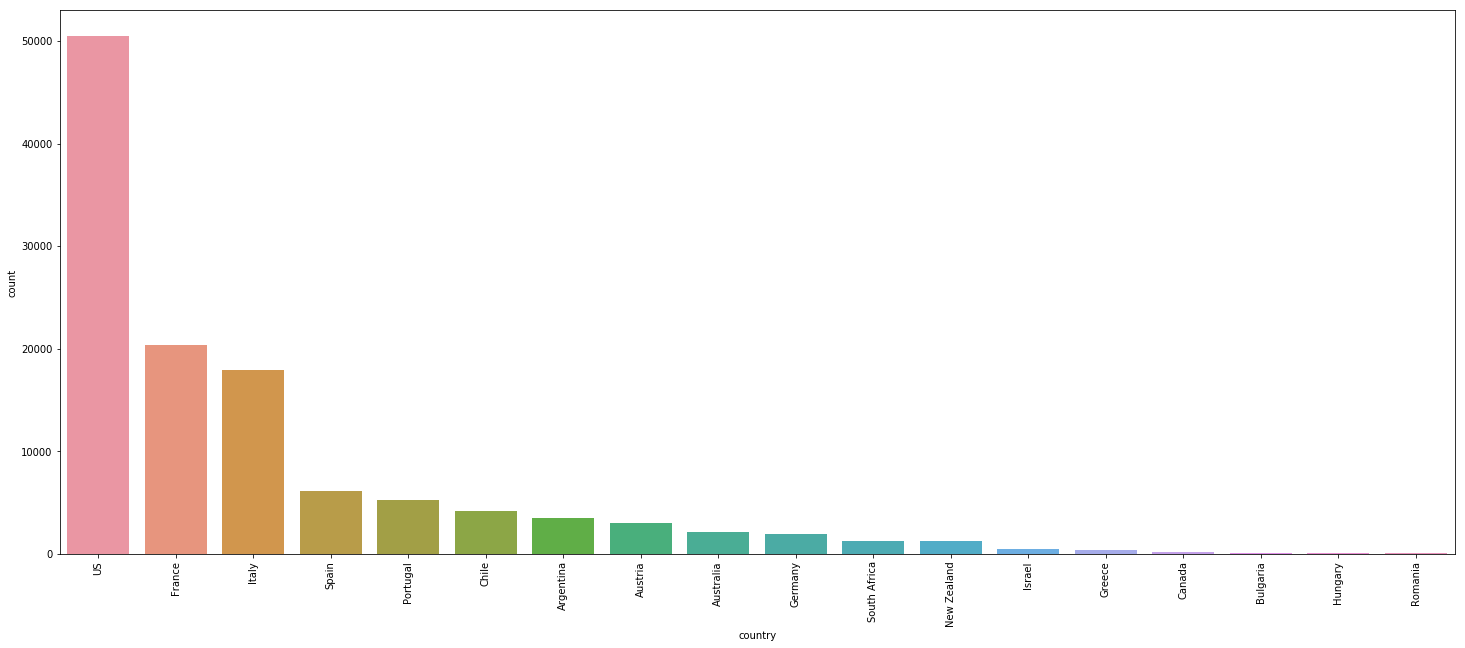

In [17]:
country = data.groupby("country").filter(lambda x: len(x)>100) #> tot perchè così prende i paesi un po' più interessanti visti i numeri
countryInfo = country['country'].value_counts().index.tolist()
fig, ax = plt.subplots(figsize = (25, 10))
sns.countplot(x = country['country'], order = countryInfo, ax = ax)
plt.xticks(rotation = 90)
plt.show()
#country.groups
#country.get_group("Argentina")

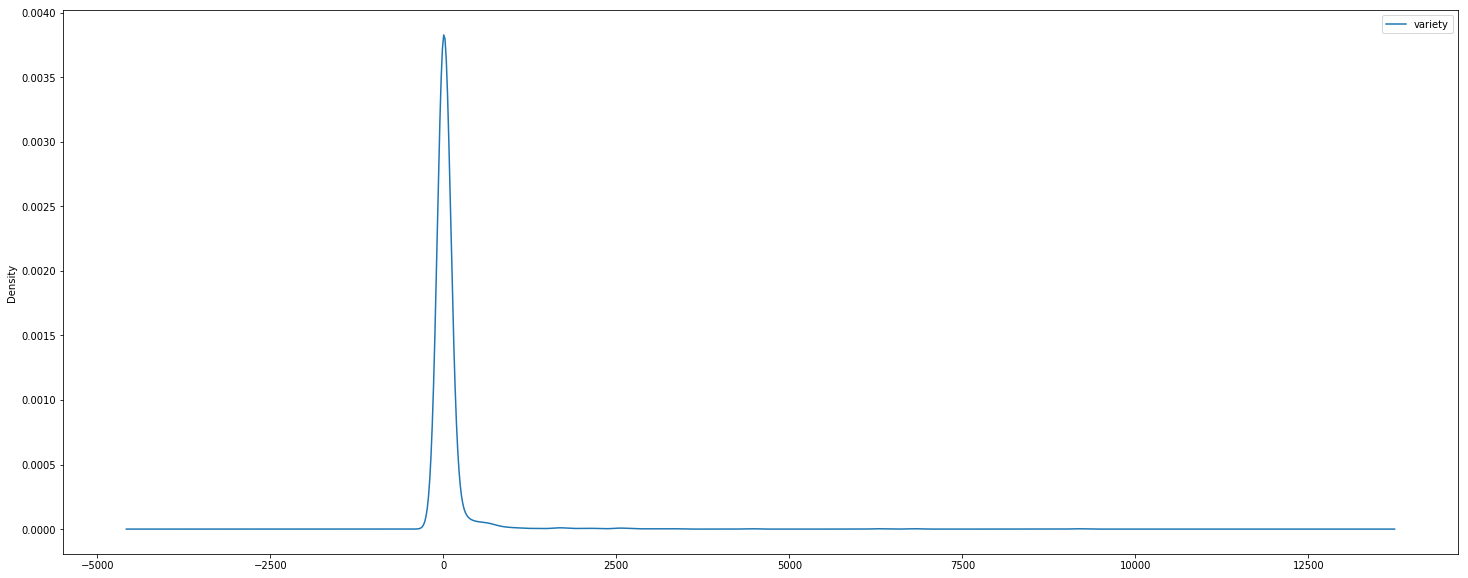

In [18]:
c1 = data.groupby(["country"]) #> tot perchè così prende i paesi un po' più interessanti visti i numeri
c1["variety"].value_counts()
fig, ax = plt.subplots(figsize = (25, 10))
ax = data.groupby(['country']).variety.value_counts().plot.kde()
plt.legend()
plt.show()
#c = pd.DataFrame(c1["variety"].value_counts())
#c1.groups
#country.groups
#country.get_group("Argentina")
#c1.head()

E:\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


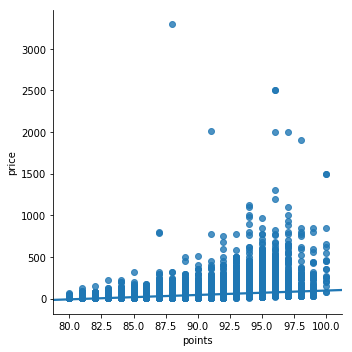

In [19]:
sns.lmplot("points","price",data=data)

-- In generale si può notare correlazione positiva fra prezzo e qualità: più è alto il prezzo, più tende ad essere buono il vino

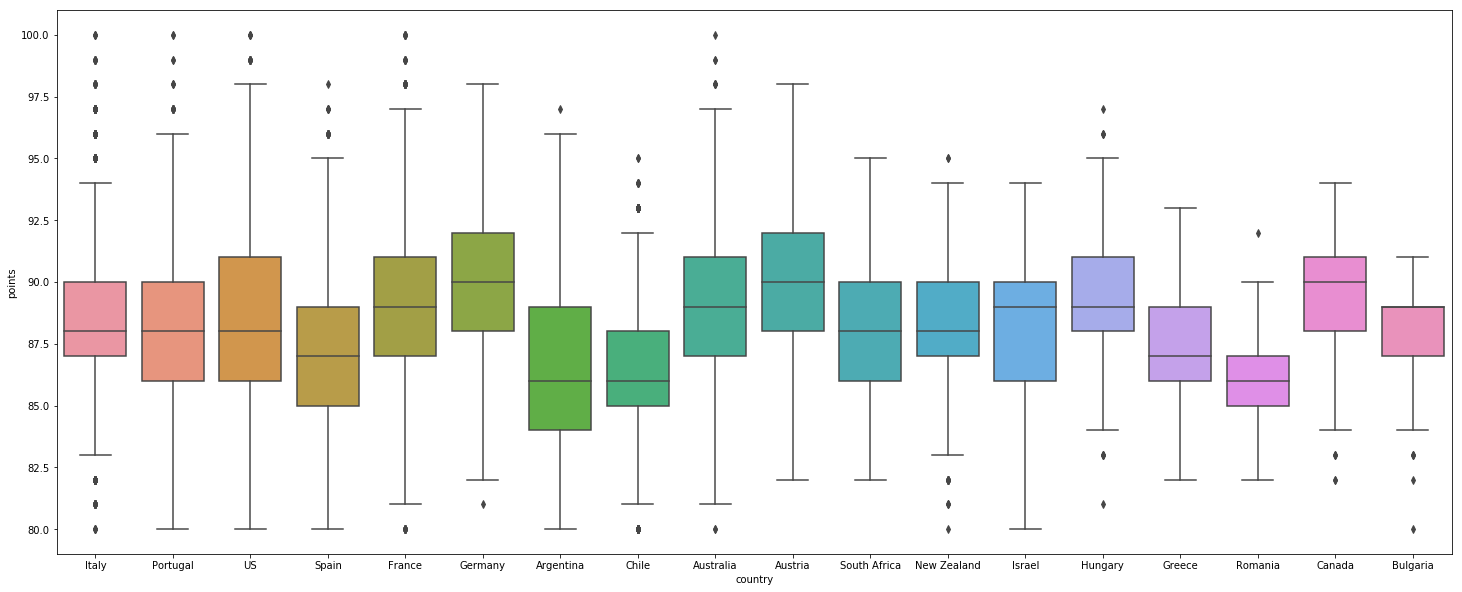

In [20]:
fig, ax = plt.subplots(figsize = (25, 10))
ax = sns.boxplot(x="country", y="points", data=country)

l'argentina, il chile, la romania e la spagna sembrano essere i paesi con le mediane più basse per quanto riguarda i punti. Mentre germania, austria e canada i più alti.

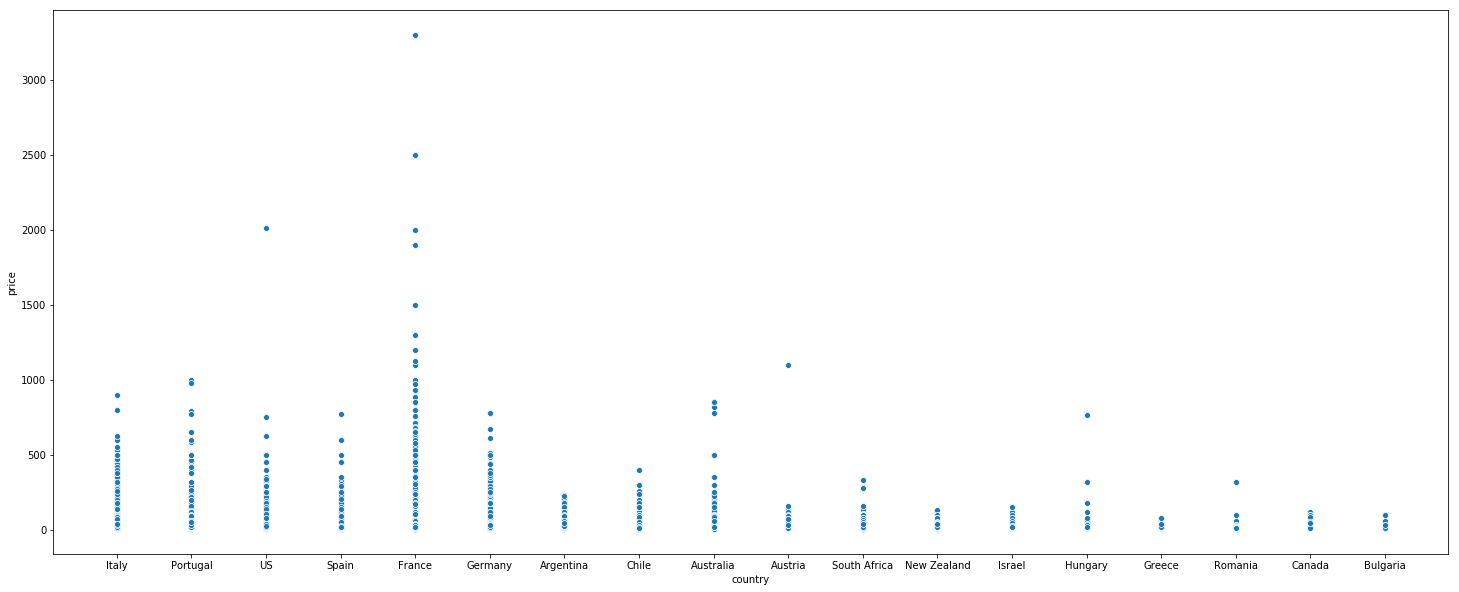

In [21]:
fig, ax = plt.subplots(figsize = (25, 10))
ax = sns.scatterplot(x="country", y="price", data=country) #il boxplot viene male??

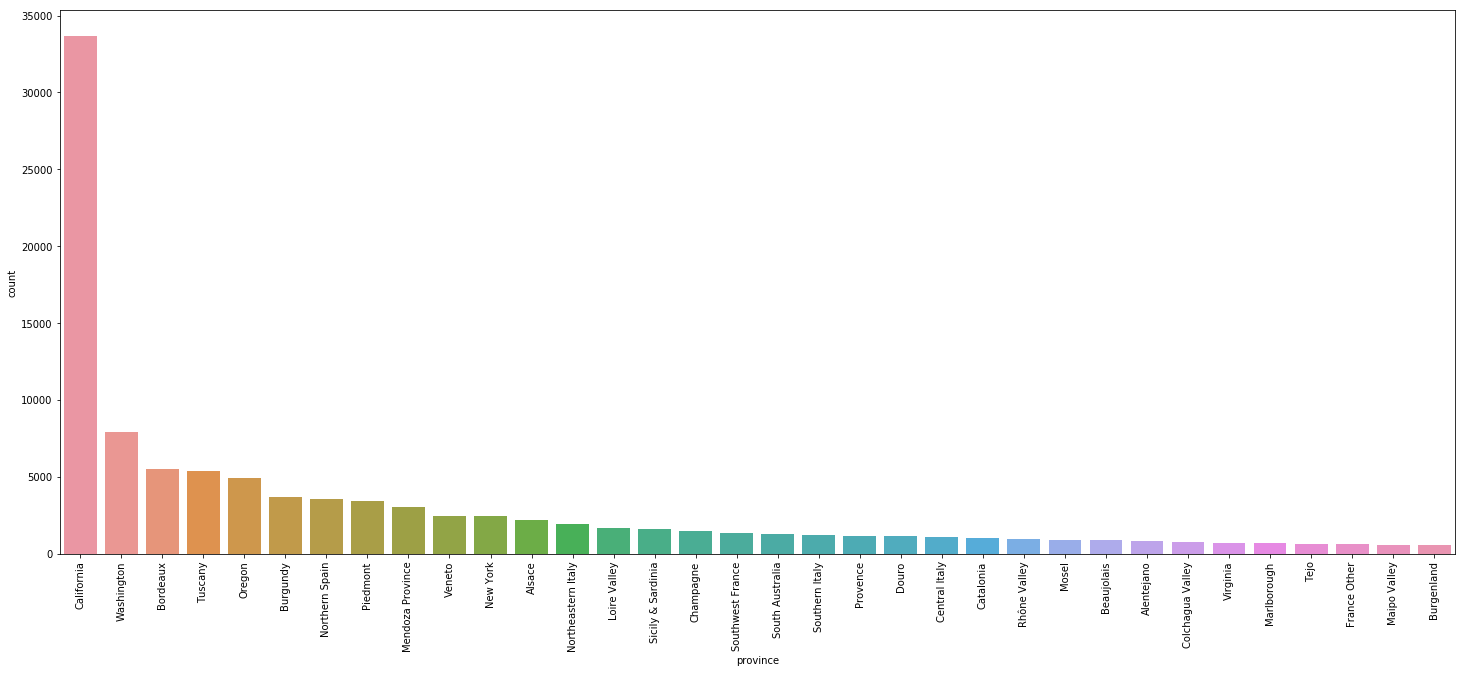

In [22]:
prov = data.groupby("province").filter(lambda x: len(x)>600) #> tot perchè così prende i paesi un po' più interessanti visti i numeri
provInfo = prov['province'].value_counts().index.tolist()
fig, ax = plt.subplots(figsize = (25, 10))
sns.countplot(x = prov['province'], order = provInfo, ax = ax)
plt.xticks(rotation = 90)
plt.show()

il dataset è palesemente "spostato" verso gli stati uniti e in particolare la california

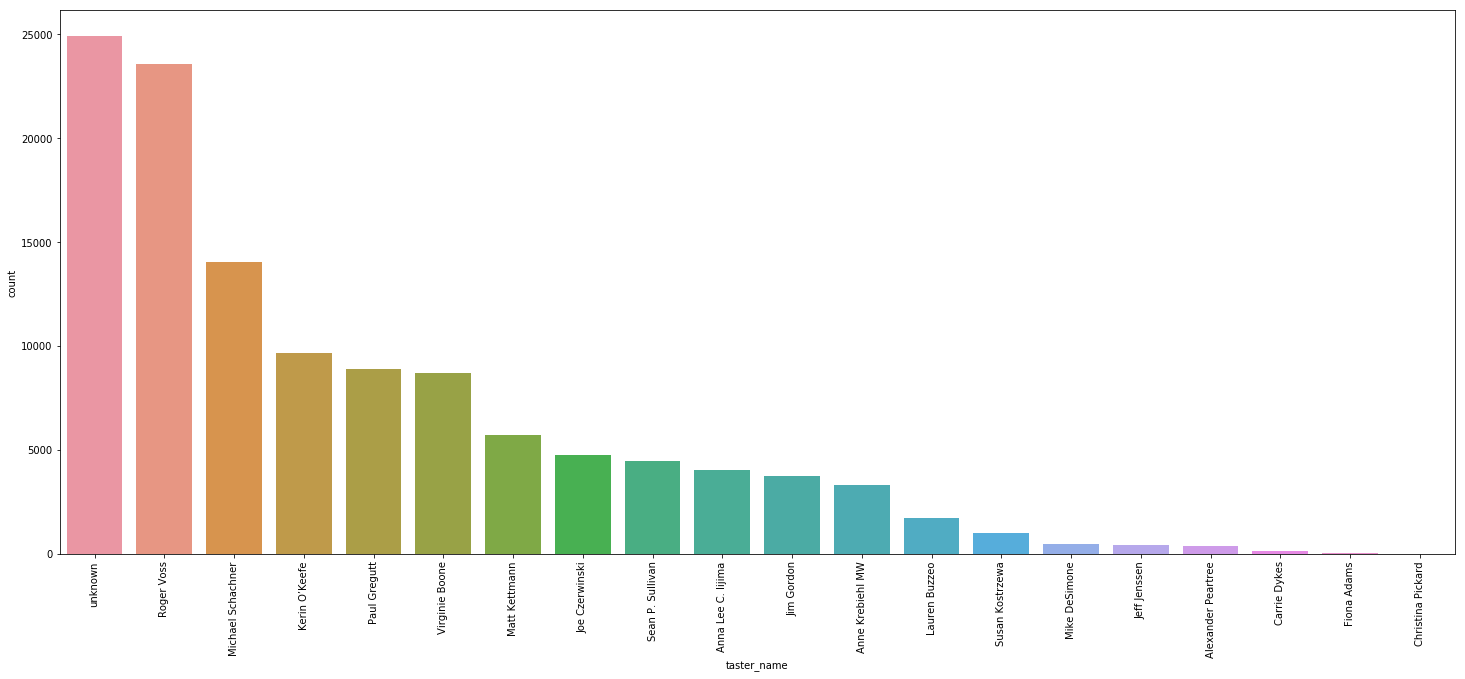

In [23]:
testers = data.groupby("taster_name").filter(lambda x: len(x)>0) #> tot perchè così prende i paesi un po' più interessanti visti i numeri
testerInfo = testers['taster_name'].value_counts().index.tolist()
fig, ax = plt.subplots(figsize = (25, 10))
sns.countplot(x = testers['taster_name'], order = testerInfo, ax = ax)
plt.xticks(rotation = 90)
plt.show()

# **Taster "experience" analysis**
Curioso per quanto riguarda i tasters, rimaneggio un po' i dati per averli in un altro dataframe più comodo per vedere come si comportano dal punto di vista della varietà di vini assaggiati

In [24]:
reviewers = data["taster_name"].unique().tolist()
len(reviewers)
countries = data["country"].unique().tolist()

In [25]:
countriesTasted = []
for r in reviewers:
    d1 = data[data["taster_name"] == r]
    temp = dict(d1["country"].value_counts())
    wines = d1["variety"].unique().tolist()
    wineries = d1["winery"].unique().tolist()
    countriesTasted.append([r,temp,wines,wineries])
#countriesTasted
stacked = pd.DataFrame(columns = ["taster","#countries","#varieties","#wineries"]+countries)
for i in range(0,len(countriesTasted)):
    stacked.loc[i,"taster"] = (countriesTasted[i][0])
    stacked.loc[i,"#countries"] = len(countriesTasted[i][1])
    stacked.loc[i,"#varieties"] = len(countriesTasted[i][2])
    stacked.loc[i,"#wineries"] = len(countriesTasted[i][3])
    for c in countriesTasted[i][1]:
        stacked.loc[i,c] = countriesTasted[i][1][c]
stacked = stacked.fillna(0)
stacked.describe()

,#countries,#varieties,#wineries,Italy,Portugal,US,Spain,France,Germany,Argentina,...,Bulgaria,Cyprus,Armenia,Switzerland,Bosnia and Herzegovina,Ukraine,Slovakia,Macedonia,China,Egypt
count,20.000000,20.000000,20.000000,20.0000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,...,20.00000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,6.850000,104.750000,1089.400000,896.0500,262.800000,2522.400000,305.800000,1017.550000,99.600000,177.150000,...,6.60000,0.500000,0.100000,0.300000,0.100000,0.700000,0.050000,0.550000,0.050000,0.050000
std,6.106726,67.143111,1401.887427,2727.0204,1167.518358,4297.775745,1351.177989,3814.543437,363.304918,791.768259,...,23.55598,2.236068,0.447214,1.128576,0.307794,2.696977,0.223607,1.538112,0.223607,0.223607
min,1.000000,6.000000,5.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,65.750000,117.000000,0.0000,0.000000,4.250000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5.000000,100.000000,527.000000,0.0000,0.000000,115.500000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,12.000000,123.000000,1339.250000,22.0000,0.250000,3932.250000,0.250000,90.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,18.000000,277.000000,5213.000000,9679.0000,5223.000000,15987.000000,6046.000000,17148.000000,1606.000000,3541.000000,...,105.00000,10.000000,2.000000,5.000000,1.000000,12.000000,1.000000,5.000000,1.000000,1.000000


E:\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


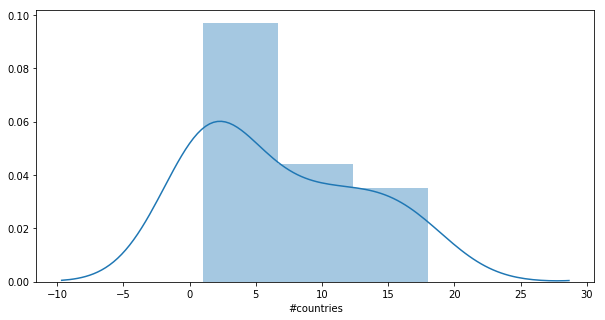

In [26]:
fig, ax = plt.subplots(figsize = (10, 5))
ax = sns.distplot(stacked["#countries"])
plt.show()

E:\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


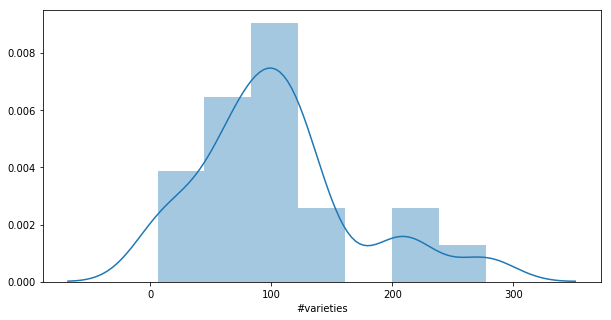

In [27]:
fig, ax = plt.subplots(figsize = (10, 5))
ax = sns.distplot(stacked["#varieties"])
plt.show()

E:\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


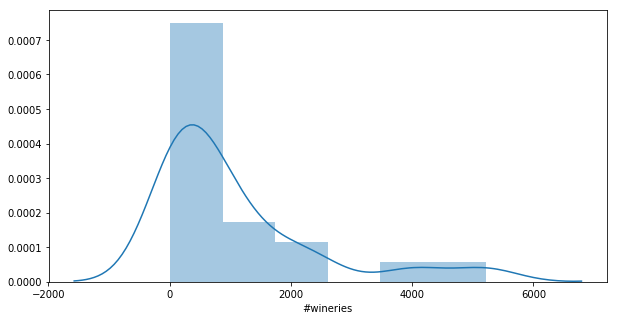

In [28]:
fig, ax = plt.subplots(figsize = (10, 5))
ax = sns.distplot(stacked["#wineries"])
plt.show()

tanti taster hanno assaggiato vini provenienti da meno di 5 paesi,in media almeno 100 varietà diverse di vino, da generalmente 500 cantine diverse

In [29]:
#testers = data.groupby(["taster_name","country"])
#for name,group in testers:
#    print(name)
#    print(len(group))

Potrebbero esserci "bias" o comunque preferenze dei vini da parte di persone che hanno assaggiato vini provenienti da meno paesi? cioè se uno ha provato vini statunitensi e basta magari ha assegnato un voto più alto di quello che uno che ha assaggiato 203020 vini da paesi diversi perchè magari non ha idea di cosa voglia dire

magari da provare a comparare i punteggi sugli stessi vini fra personaggi diversi

controlla anche le cose della designation

In [30]:
desig = data.groupby(["designation"])
desig["designation"].count()


designation
#19 Phantom Limb Belmont Vineyard                           1
#50 Mon Chou                                                1
#SocialSecret                                               1
%@#$!                                                       1
&                                                           2
'61 Rosé                                                    1
'A Rina                                                     1
'Blend 105' Red Wine                                        1
'Na Vota                                                    1
'P'                                                         1
'S'                                                         1
'Unfiltered'                                                1
'Vie!'                                                      1
'l Clumbé                                                   1
(+)                                                         1
(Steen)                                                   

In [31]:
revs = data.groupby(["title"]).filter(lambda x: len(x) >= 2)
len(revs)

2082

-- La grandissima maggioranza delle recensioni è "singola", solo una persona ha assaggiato e ha dato il voto? o dups?

In [32]:
revs["title"].unique()

array(['Roland Champion NV Brut Rosé  (Champagne)',
       'Ferrari-Carano 2014 Siena Red (Sonoma County)',
       'Bellussi NV Extra Dry  (Prosecco di Valdobbiadene)',
       'Spagnol NV Col del Sas Extra Dry  (Prosecco di Valdobbiadene)',
       "L'Antica Quercia 2007 Arió Extra Dry  (Prosecco di Conegliano)",
       'Chambers Rosewood Vineyards NV Rare Muscat (Rutherglen)',
       'Chambers Rosewood Vineyards NV Rare Muscadelle (Rutherglen)',
       'Chambers Rosewood Vineyards NV Grand Muscat (Rutherglen)',
       'Jacquart NV Brut Mosaïque  (Champagne)',
       'Roederer Estate NV Brut Sparkling (Anderson Valley)',
       'Chanoine NV Tzarina No 1 Brut  (Champagne)',
       'Flying Goat Cellars 2012 Bien Nacido Vineyard Pinot Noir (Santa Maria Valley)',
       'Steininger 2016 Grüner Veltliner (Kamptal)',
       'Borgo Maragliano NV Brut Chardonnay (Piedmont)',
       'Domaine Michel Goubard 2014 Mont-Avril  (Côte Chalonnaise)',
       "Quinta do Sagrado 2008 VT '08 Red (Douro)",


In [33]:
singleTitleExample = revs[revs["title"] == "Gloria Ferrer NV Sonoma Brut Sparkling (Sonoma County)"]
singleTitleExample

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,Desig_Code,Taster_Code,Variety_Code,Winery_Code,Country_Code,Province_Code
3209,US,"Creamy, lush and somewhat robust, this dry spa...",Sonoma Brut,90,22.0,California,Sonoma County,Sonoma,Virginie Boone,@vboone,Gloria Ferrer NV Sonoma Brut Sparkling (Sonoma...,Sparkling Blend,Gloria Ferrer,31443,18,553,8001,40,51
4399,US,"Made predominantly from Pinot Noir, this is an...",Sonoma Brut,88,22.0,California,Sonoma County,Sonoma,Virginie Boone,@vboone,Gloria Ferrer NV Sonoma Brut Sparkling (Sonoma...,Sparkling Blend,Gloria Ferrer,31443,18,553,8001,40,51
27773,US,A wonderfully drinkable sparkling wine that ap...,Sonoma Brut,90,20.0,California,Sonoma County,Sonoma,unknown,unknown,Gloria Ferrer NV Sonoma Brut Sparkling (Sonoma...,Sparkling Blend,Gloria Ferrer,31443,19,553,8001,40,51
63179,US,"Made from mostly Pinot Noir grapes, with an ad...",Sonoma Brut,92,22.0,California,Sonoma County,Sonoma,Virginie Boone,@vboone,Gloria Ferrer NV Sonoma Brut Sparkling (Sonoma...,Sparkling Blend,Gloria Ferrer,31443,18,553,8001,40,51
81563,US,This wine shows lots of finesse for the price....,Sonoma Brut,89,24.0,California,Sonoma County,Sonoma,unknown,unknown,Gloria Ferrer NV Sonoma Brut Sparkling (Sonoma...,Sparkling Blend,Gloria Ferrer,31443,19,553,8001,40,51
94321,US,"A bit rough and scouring in texture, this tast...",Sonoma Brut,85,20.0,California,Sonoma County,Sonoma,unknown,unknown,Gloria Ferrer NV Sonoma Brut Sparkling (Sonoma...,Sparkling Blend,Gloria Ferrer,31443,19,553,8001,40,51
100738,US,"A good, dry and elegant bubbly. Shows crisp fl...",Sonoma Brut,89,20.0,California,Sonoma County,Sonoma,unknown,unknown,Gloria Ferrer NV Sonoma Brut Sparkling (Sonoma...,Sparkling Blend,Gloria Ferrer,31443,19,553,8001,40,51
109001,US,From almost 92% Pinot Noir with the remainder ...,Sonoma Brut,88,22.0,California,Sonoma County,Sonoma,Virginie Boone,@vboone,Gloria Ferrer NV Sonoma Brut Sparkling (Sonoma...,Sparkling Blend,Gloria Ferrer,31443,18,553,8001,40,51
122208,US,This bubbly is rich in cherry and raspberry fr...,Sonoma Brut,86,20.0,California,Sonoma County,Sonoma,unknown,unknown,Gloria Ferrer NV Sonoma Brut Sparkling (Sonoma...,Sparkling Blend,Gloria Ferrer,31443,19,553,8001,40,51


In [34]:
singleTitleExample["taster_name"].unique()

array(['Virginie Boone', 'unknown'], dtype=object)

In [35]:
ex1 = revs[revs["title"] == "Roland Champion NV Brut Rosé  (Champagne)"]
ex1

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,Desig_Code,Taster_Code,Variety_Code,Winery_Code,Country_Code,Province_Code
63,France,"This fat, yeasty Champagne is comprised predom...",Brut Rosé,86,58.0,Champagne,Champagne,unknown,Roger Voss,@vossroger,Roland Champion NV Brut Rosé (Champagne),Champagne Blend,Roland Champion,4623,15,121,13409,15,75
94327,France,"With its red berry flavor and touch of citrus,...",Brut Rosé,85,58.0,Champagne,Champagne,unknown,Roger Voss,@vossroger,Roland Champion NV Brut Rosé (Champagne),Champagne Blend,Roland Champion,4623,15,121,13409,15,75


In [36]:
ex1 = revs[revs["title"] == "Ferrari-Carano 2014 Siena Red (Sonoma County)"]
ex1

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,Desig_Code,Taster_Code,Variety_Code,Winery_Code,Country_Code,Province_Code
90,US,"This blend of Sangiovese, Malbec, Cabernet Sau...",Siena,88,23.0,California,Sonoma County,Sonoma,Virginie Boone,@vboone,Ferrari-Carano 2014 Siena Red (Sonoma County),Red Blend,Ferrari-Carano,30871,18,473,7301,40,51
30837,US,"This is made from a majority of Sangiovese, wi...",Siena,87,21.0,California,Sonoma County,Sonoma,Virginie Boone,@vboone,Ferrari-Carano 2014 Siena Red (Sonoma County),Red Blend,Ferrari-Carano,30871,18,473,7301,40,51


In [37]:
ex1 = revs[revs["title"] == "Liebart-Régnier NV Brut  (Champagne)"]
ex1 

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,Desig_Code,Taster_Code,Variety_Code,Winery_Code,Country_Code,Province_Code
3246,France,There are flavors of peanuts as well as the mo...,Brut,86,56.0,Champagne,Champagne,unknown,Roger Voss,@vossroger,Liebart-Régnier NV Brut (Champagne),Champagne Blend,Liebart-Régnier,4474,15,121,10061,15,75
52525,France,"This small producer, based in the Marne Valley...",Brut,87,49.0,Champagne,Champagne,unknown,Roger Voss,@vossroger,Liebart-Régnier NV Brut (Champagne),Champagne Blend,Liebart-Régnier,4474,15,121,10061,15,75


Stessi reviewer due descrizioni diverse, con voti diversi, sullo stesso titolo, ma con prezzi diversi? Wot? Sempre un problema che molti reviewer sono senza nome